In [113]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import emd
from scipy import signal
from itertools import cycle
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW


In [114]:
# Read the text file into a DataFrame
file_path = 'data/TS_data.txt'
delimiter = ';--:--;'
df = pd.read_csv(file_path, delimiter=delimiter)
df.columns = ['time', 'value']


/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_28256/3467039344.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, delimiter=delimiter)


<Axes: xlabel='time', ylabel='log(debit) (m3/s)'>

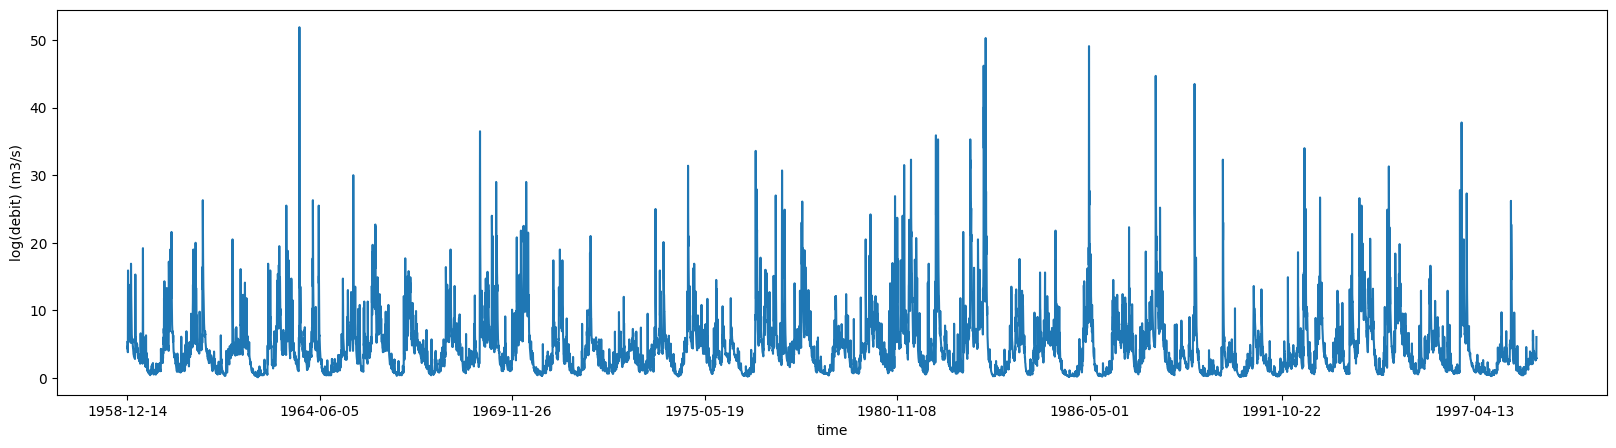

In [115]:
df[4000:-4000].plot(x='time', y='value', figsize=(20, 5), legend=False, ylabel='log(debit) (m3/s)')

<Axes: xlabel='Month', ylabel='Average Value'>

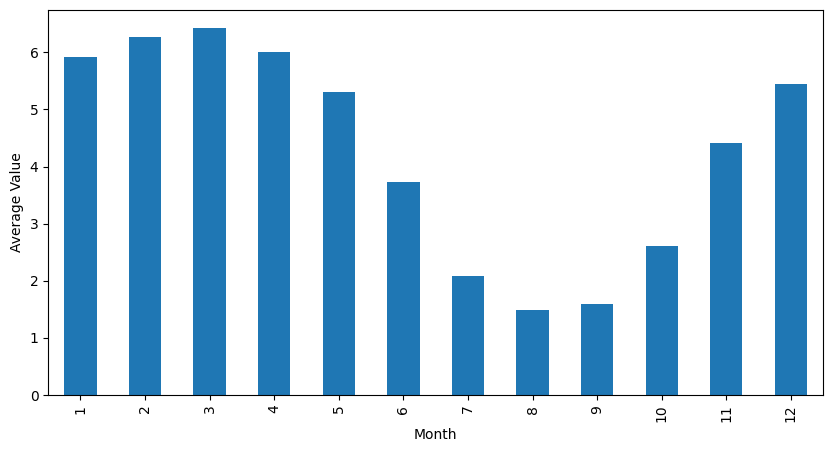

In [124]:
# Create a new column with the month
df['month'] = pd.DatetimeIndex(df['time']).month

# Compute the average value for each month
monthly_avg = df.groupby('month')['value'].mean()

# Plot the monthly average values
monthly_avg.plot(kind='bar', figsize=(10, 5), xlabel='Month', ylabel='Average Value')


In [117]:
data = df['value'].values[4000:-4000]
# interpolate missing values and take the log of the data
data = np.interp(
    np.arange(len(data)),
    np.arange(len(data))[~(data==0.0)],
    np.log(data).astype(float)[~(data==0.0)]
)

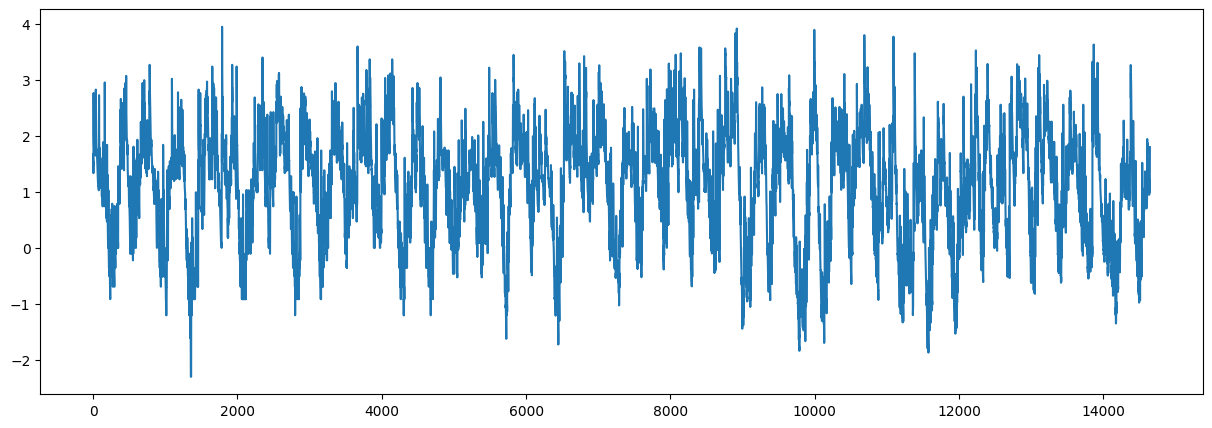

In [118]:
# plot the new data
plt.figure(figsize=(15, 5))
plt.plot(data)
plt.show()


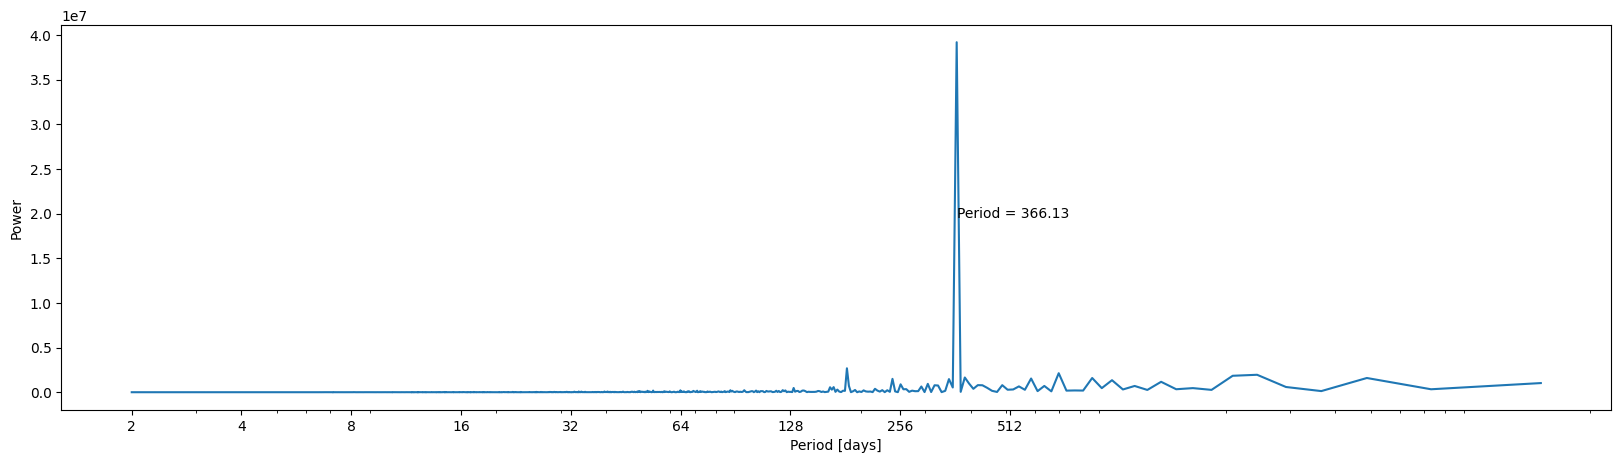

In [119]:
# Calculate the FFT
fft = np.fft.fft(data)
fft = fft[1 : len(fft) // 2]

# Calculate the power spectrum
power_spectrum = np.abs(fft) ** 2

# Calculate the frequencies
sample_freq = np.fft.fftfreq(len(data), d=1)
sample_freq = sample_freq[1 : len(sample_freq) // 2]

# Plot the power spectrum as a function of the period
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(1 / sample_freq, power_spectrum)

# Plot the highest peak in the power spectrum as a vertical line
max_period = 1 / sample_freq[np.argmax(power_spectrum)]
# ax.axvline(max_period, color="red")

PLOTTED_PERIODS = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Add text to this line
ax.text(
    max_period,
    0.5 * np.max(power_spectrum),
    "Period = " + str(np.round(max_period, 2))
)
ax.set_xlabel("Period [days]")
ax.set_ylabel("Power")
# ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
# ax.set_xlim(2, 1000)
plt.show()


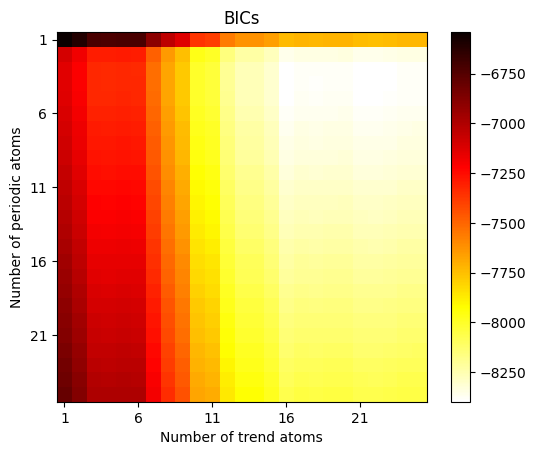

Preferred number of trend atoms: 22
Preferred number of periodic atoms: 4


In [120]:
# Extract trend (mean) and seasonality (periodic component)
def generate_trend_atoms(k, length):
    """Generate trend atoms of given length."""
    atoms = np.zeros((k, length))
    for i in range(k):
        atoms[i, :] = np.linspace(0, 1, length) ** i
    return atoms

def generate_periodic_atoms(periods, length):
    """Generate periodic atoms of given periods and length."""
    atoms = np.zeros((2 * len(periods), length))
    for i, period in enumerate(periods):
        atoms[i, :] = np.sin(np.arange(length) * 2 * np.pi / period)
        atoms[i + len(periods), :] = np.cos(np.arange(length) * 2 * np.pi / period)
    return atoms

# extract trend (mean) and seasonality (periodic component) using least squares
BICs = np.zeros((25, 25))
for i in range(1, 26):
    for j in range(1, 26):
        nb_periods = i
        periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
        periodic_atoms = generate_periodic_atoms(periods, len(data))
        nb_trend_atoms = j
        trend_atoms = generate_trend_atoms(nb_trend_atoms, len(data))
        atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

        # Calculate the least squares solution
        solution = np.linalg.lstsq(atoms.T, data, rcond=None)[0]

        # Calculate the residuals
        residuals = data - np.dot(atoms.T, solution)

        # Calculate the likelihood
        likelihood = -0.5 * len(residuals) * np.log(np.sum(residuals**2 / len(residuals)))

        # Calculate the number of parameters (k) in your model
        k = len(solution)

        # Calculate BIC
        n = len(data)
        bic = -2 * likelihood + k * np.log(n)
        BICs[i - 1, j - 1] = bic

# Plot the BICs
plt.imshow(BICs, cmap="hot_r")
plt.colorbar()
plt.xlabel("Number of trend atoms")
plt.ylabel("Number of periodic atoms")
plt.xticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.yticks(np.arange(0, 25, 5), np.arange(1, 26, 5))
plt.title("BICs")
plt.show()

argmin_BICs = np.argmin(BICs)
nb_periods, nb_trend_atoms = np.unravel_index(argmin_BICs, BICs.shape)
nb_periods += 1
nb_trend_atoms += 1
        
print("Preferred number of trend atoms: " + str(nb_trend_atoms))
print("Preferred number of periodic atoms: " + str(nb_periods))

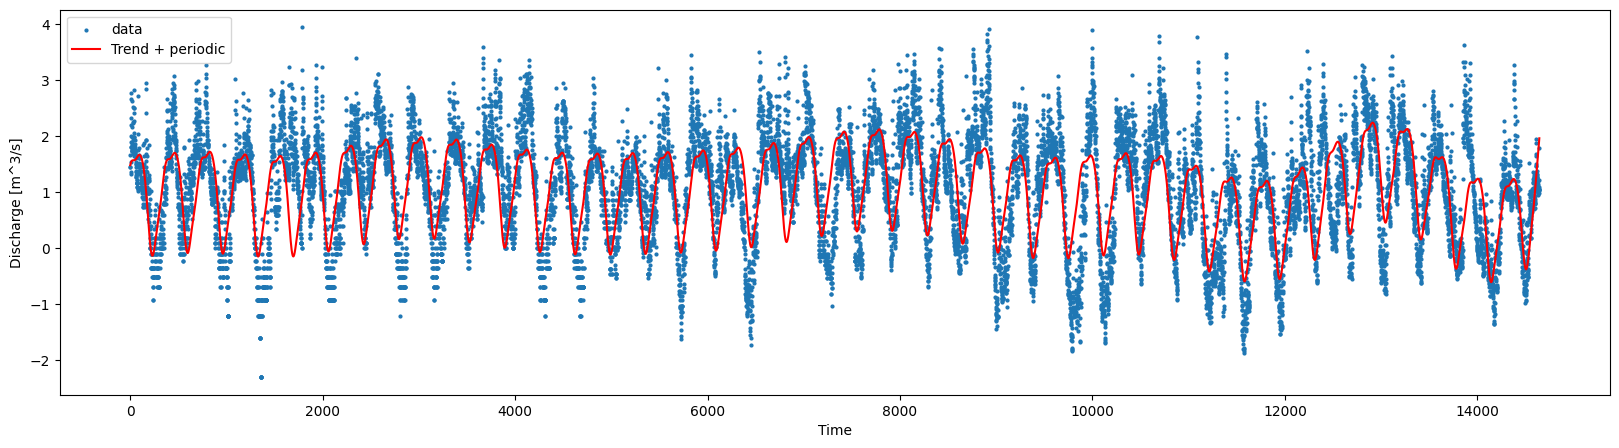

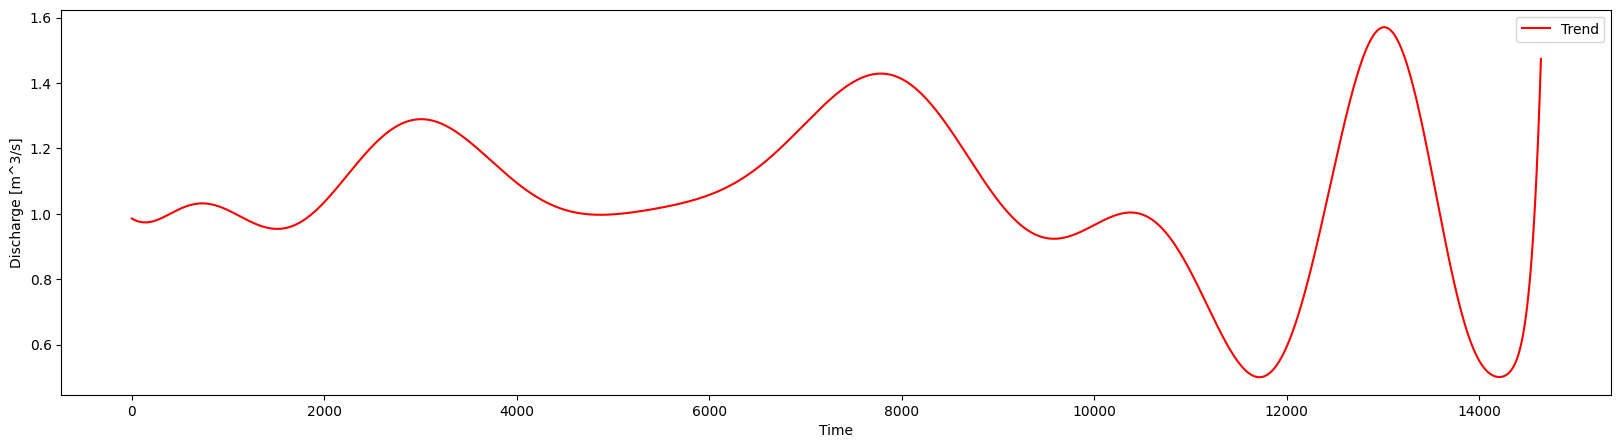

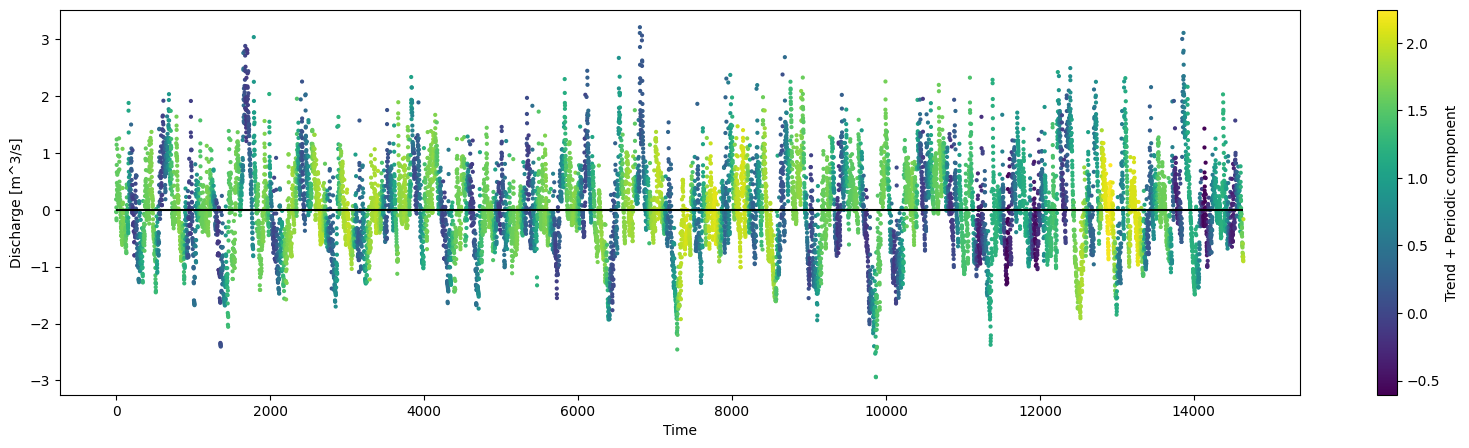

In [121]:
periods = [max_period / p for p in np.arange(1, nb_periods + 1)]
periodic_atoms = generate_periodic_atoms(periods, len(data))
trend_atoms = generate_trend_atoms(nb_trend_atoms, len(data))
atoms = np.concatenate((periodic_atoms, trend_atoms), axis=0)

# Calculate the least squares solution
solution = np.linalg.lstsq(atoms.T, data, rcond=None)[0]

# Plot the trend and periodic components
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.scatter(np.arange(len(data)), data, label="data", s=4)
ax.plot(np.arange(len(data)), np.dot(atoms.T, solution), label="Trend + periodic", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("Discharge [m^3/s]")
ax.legend()
plt.show()

# Plot the trend
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
ax.plot(np.arange(len(data)), np.dot(trend_atoms.T, solution[nb_periods * 2:]), label="Trend", color="red")
ax.set_xlabel("Time")
ax.set_ylabel("Discharge [m^3/s]")
ax.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(data)), data - np.dot(atoms.T, solution), c=np.dot(atoms.T, solution), s=4)
plt.hlines(0, np.arange(len(data))[0], np.arange(len(data))[-1], color="black")
plt.colorbar(label="Trend + Periodic component")
plt.xlabel("Time")
plt.ylabel("Discharge [m^3/s]")
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


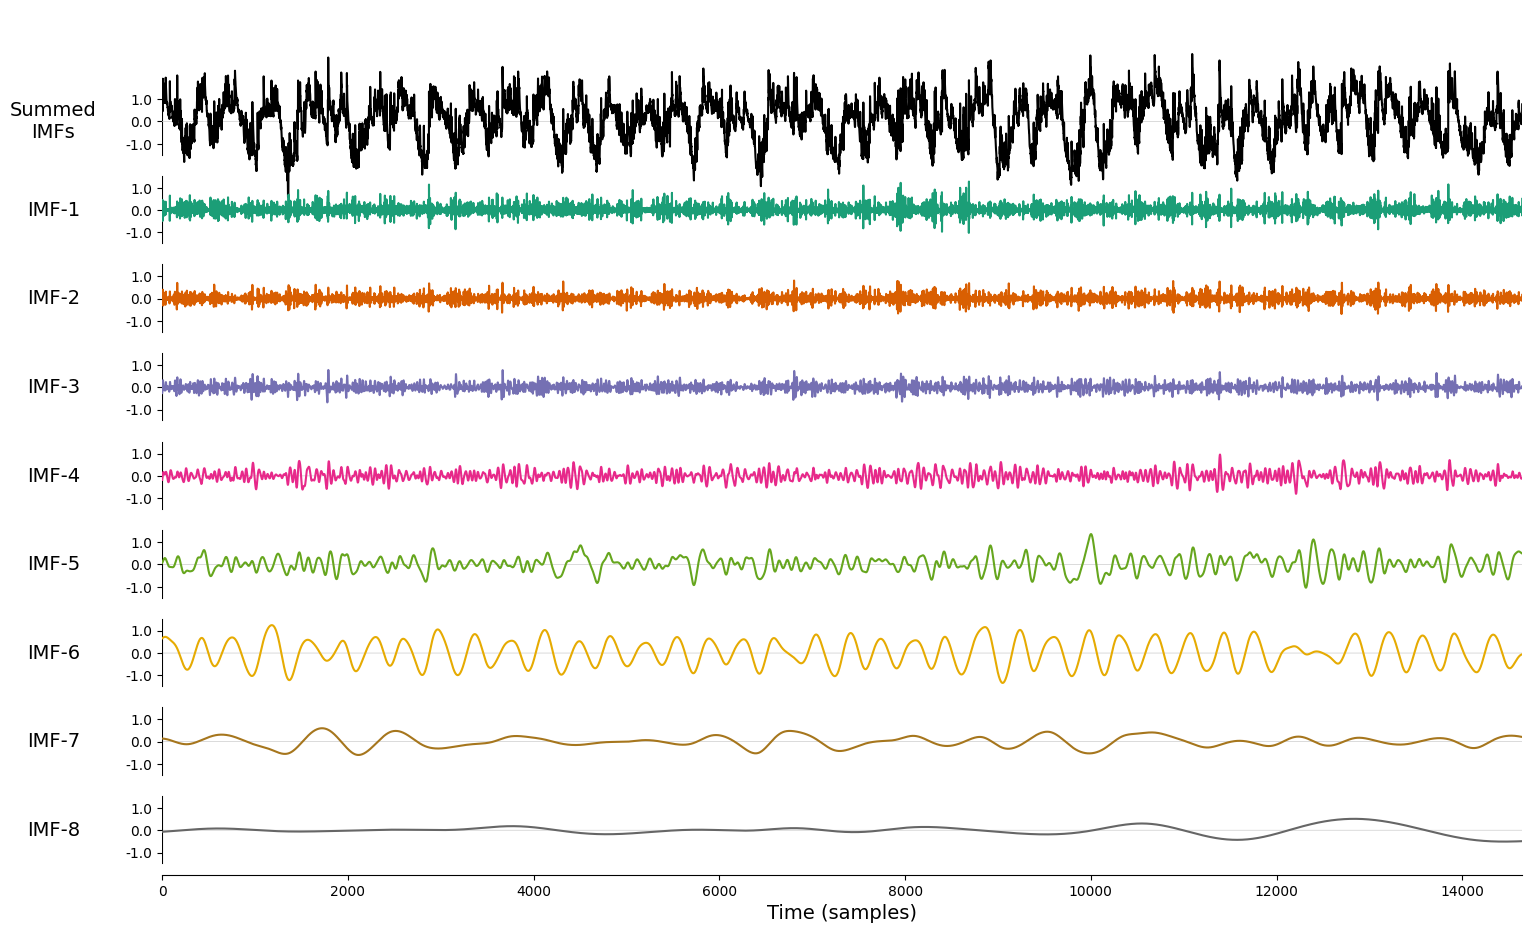

In [122]:
# Calculate the EMD
imf = emd.sift.ensemble_sift(data, max_imfs=8, nensembles=1024, nprocesses=32, ensemble_noise=1)
emd.plotting.plot_imfs(imf)

IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')

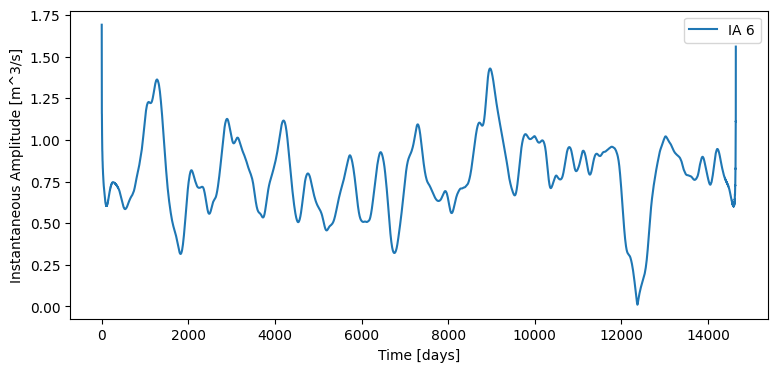

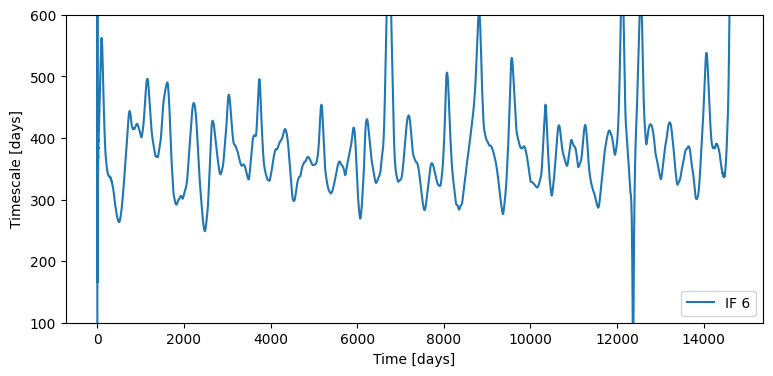

In [123]:
# Plot IA k+1 and IF k+1
k = 5
fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(IA[:, k], label="IA 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Instantaneous Amplitude [m^3/s]")
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 4)
ax.plot(1 / IF[:, k], label="IF 6")
ax.set_xlabel("Time [days]")
ax.set_ylabel("Timescale [days]")
ax.set_ylim(100, 600)
ax.legend()
plt.show()


/Users/paulbonin/opt/anaconda3/envs/TS/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 5094, using nperseg = 5094
  warnings.warn('nperseg = {0:d} is greater than input length '
/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_28256/1201383706.py:10: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
/var/folders/g8/qb9zv72s0g96lhlhgth8d3ym0000gn/T/ipykernel_28256/1201383706.py:14: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


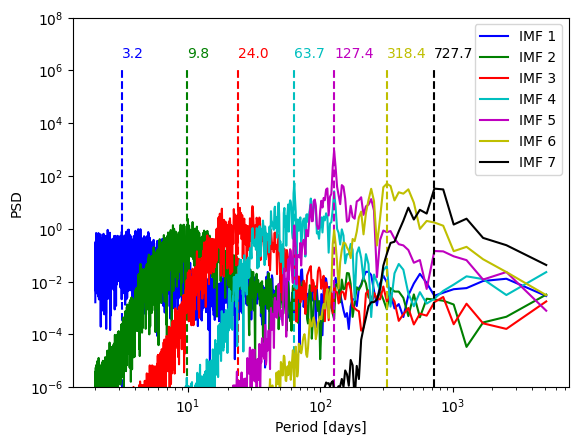

In [ ]:
# Compute PSDs of the IMFs
f, Pxx = signal.welch(imf.T, fs=1, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
# ax.set_xlim(2, 1000)
plt.show()

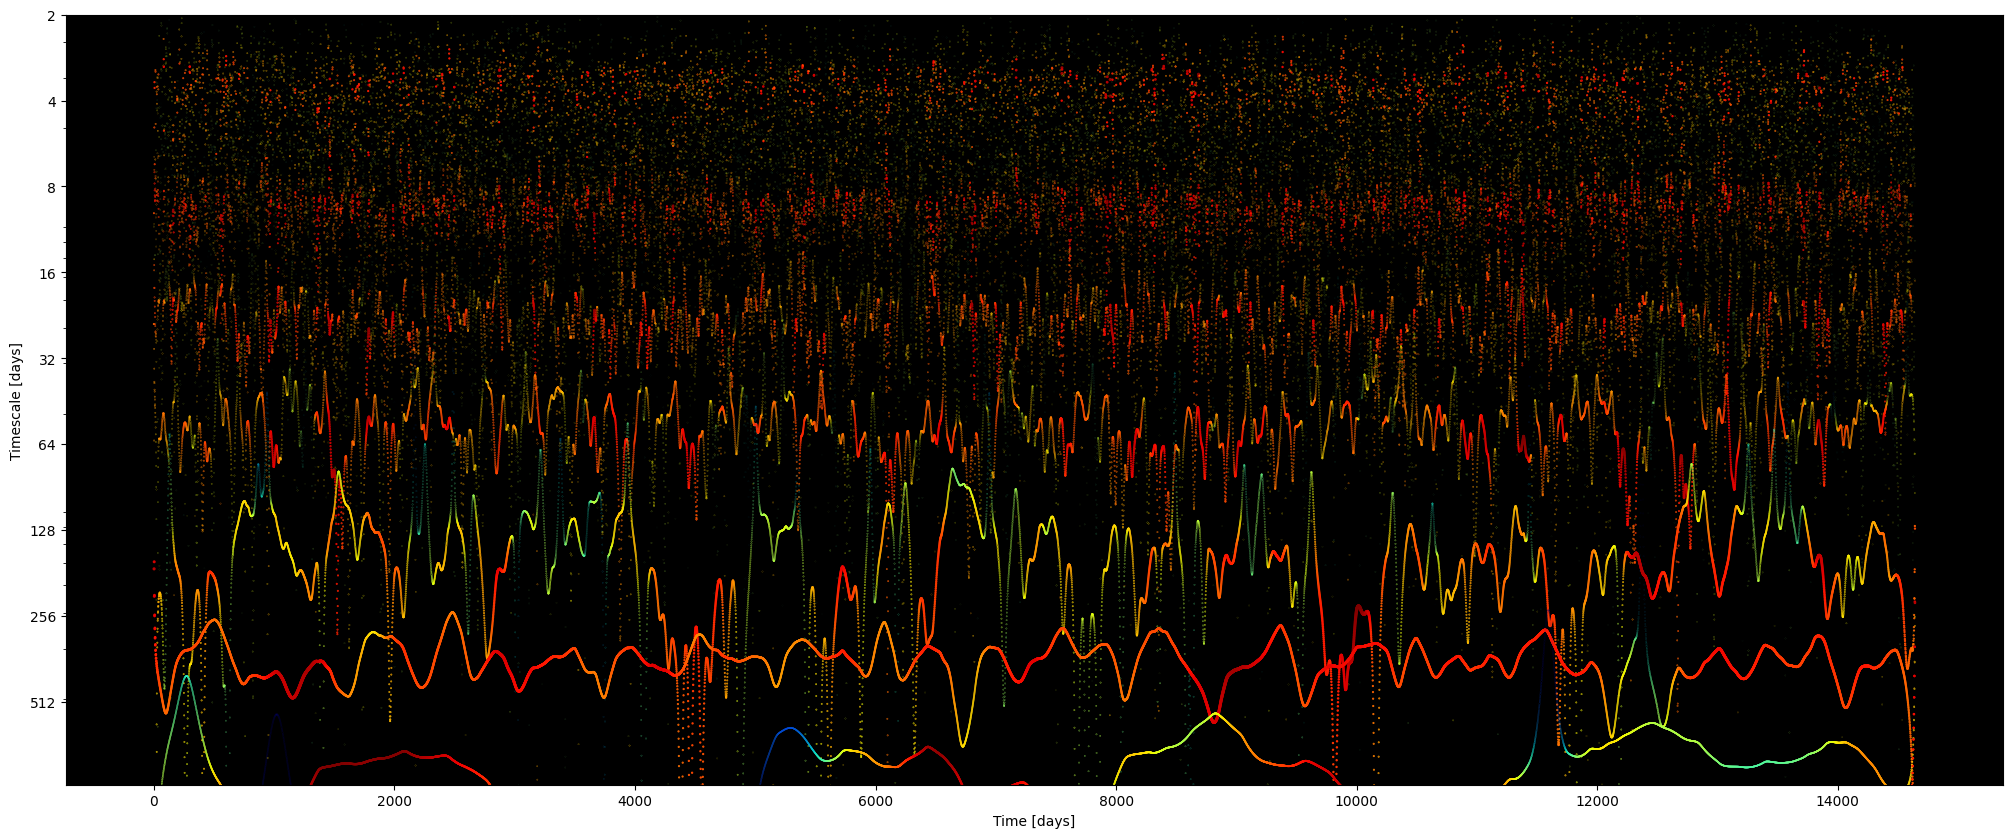

In [125]:
plt.figure(figsize=(25, 10))
# Set background color
plt.rcParams['axes.facecolor'] = "k"
for i in range(imf.shape[1]):
    plt.scatter(np.arange(len(imf)), IF[:, i], c=np.log(IA[:, i]), cmap="jet", s=1*IA[:, i]**2, label="IMF %d" % (i +1))
plt.xlabel("Time [days]")
plt.ylabel("Timescale [days]")
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.show()

plt.rcParams['axes.facecolor'] = "w"


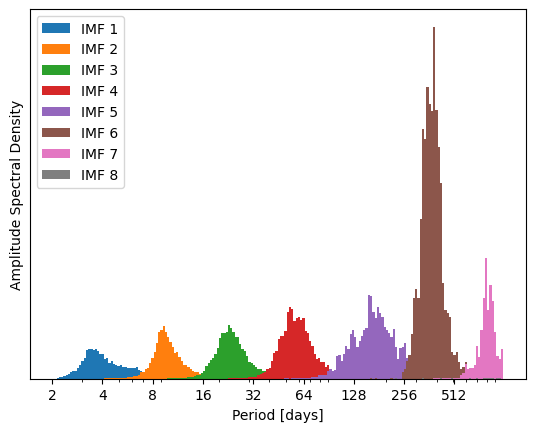

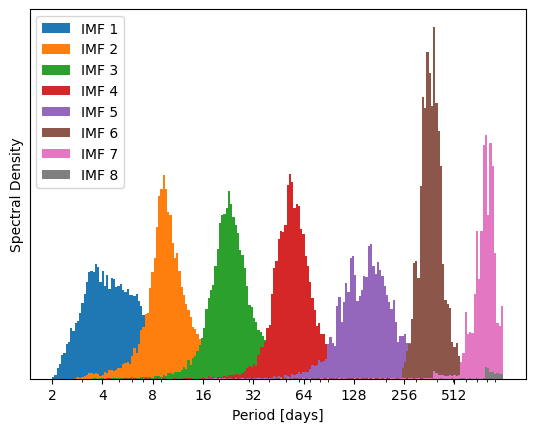

In [ ]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')

f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
f, hht_0a = emd.spectra.hilberthuang(IF, np.ones_like(IA), freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)

# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Amplitude Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()

# Plot the HHT
for i in range(hht.shape[1]):
    plt.bar(1 / freq_centres, hht_0a[:, i], label="IMF %d" % (i +1), width=1 / freq_edges[1:] - 1 / freq_edges[:-1])
plt.xlabel("Period [days]")
plt.ylabel("Spectral Density")
# plt.title("BSRN data from " + paths[i_path])
plt.xscale("log")
plt.xticks(PLOTTED_PERIODS, PLOTTED_PERIODS)
plt.yticks([])
plt.legend()
plt.show()

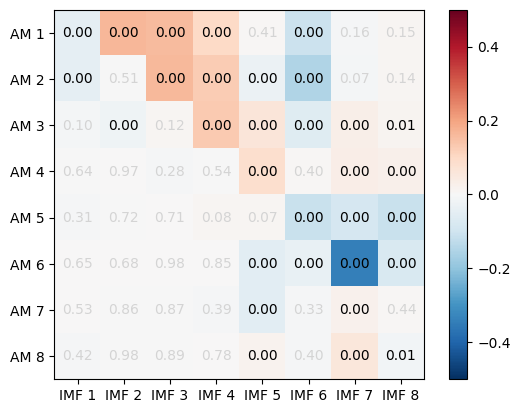

In [ ]:
# Compute Kendall's taucorrelation matrix between IA and IMFs
from scipy.stats import kendalltau

taus = np.zeros((imf.shape[1], imf.shape[1]))
ps = np.zeros((imf.shape[1], imf.shape[1]))
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        tau, p = kendalltau(IA[:, i], imf[:, j])
        taus[i, j] = tau
        ps[i, j] = p

# Plot the correlation matrix as a heatmap (p values are written in the cells)
plt.imshow(taus, cmap="RdBu_r", vmin=-0.5, vmax=0.5)
for i in range(imf.shape[1]):
    for j in range(imf.shape[1]):
        plt.text(j, i, "%.2f" % ps[i, j], ha="center", va="center", color="#000000" if ps[i, j] < 0.05 else "#d4d4d4")
plt.xticks(np.arange(imf.shape[1]), ["IMF %d" % (i + 1) for i in range(imf.shape[1])])
plt.yticks(np.arange(imf.shape[1]), ["AM %d" % (i + 1) for i in range(imf.shape[1])])
plt.colorbar()
plt.show()


In [ ]:
def resample_float_rate_linear_interp(x, y, rate):
    """Resample a float rate time series using linear interpolation."""
    # Create a new time series with the desired rate
    new_x = np.arange(x[0], x[-1], rate)
    # Interpolate the original time series at the new time series
    new_y = np.interp(new_x, x, y)
    return new_x, new_y

In [ ]:
resample_rates = np.arange(24, 72, 3)
freq_edges, freq_centres = emd.spectra.define_hist_bins(1/1000, 1/2, 200, 'log')
SWMFs = np.zeros((len(resample_rates), 7))
SWUQs = np.zeros((len(resample_rates), 7))
SWLQs = np.zeros((len(resample_rates), 7))
for i_rr, rr in enumerate(resample_rates):
    freq_ratio = 24 / rr
    data_resampled = resample_float_rate_linear_interp(np.arange(len(data)), data, rr / 24)[1]
    print(len(data_resampled))
    imf = emd.sift.ensemble_sift(data_resampled, max_imfs=7, nensembles=1024, nprocesses=32, ensemble_noise=4)
    IP, IF, IA = emd.spectra.frequency_transform(imf, 1, 'hilbert')
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_edges, mode='amplitude', sum_time=True, sum_imfs=False)
    ws = [DescrStatsW(freq_ratio * f, weights=hht[:, i]) for i in range(hht.shape[1])]
    SWMFs[i_rr, :] = np.array([w.mean for w in ws])
    SWUQs[i_rr, :] = np.array([w.quantile([0.75], return_pandas=False)[0] for w in ws])
    SWLQs[i_rr, :] = np.array([w.quantile([0.25], return_pandas=False)[0] for w in ws])


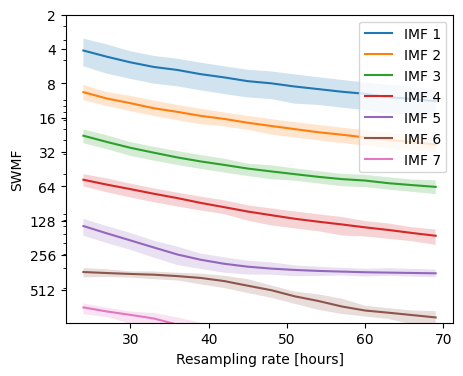

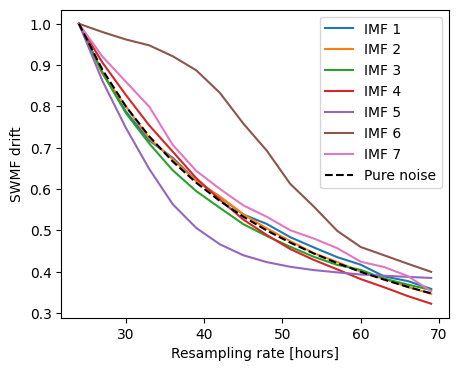

In [ ]:
# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i], label="IMF %d" % (i +1))
    # Plot upper and lower quartiles
    plt.fill_between(resample_rates, SWUQs[:, i], SWLQs[:, i], alpha=0.2)

# Plot the behaviour of the SWMF for a pure noise signal
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF")
plt.yscale("log")
plt.yticks([1/x for x in PLOTTED_PERIODS], PLOTTED_PERIODS)
plt.ylim(1/1000, 1/2)
plt.legend()
plt.show()

# Plot the SWMFs
plt.figure(figsize=(5, 4))
for i in range(imf.shape[1]):
    plt.plot(resample_rates, SWMFs[:, i] / SWMFs[0, i], label="IMF %d" % (i +1))
# Plot the behaviour of the SWMF for a pure noise signal
plt.plot(resample_rates, 24 / resample_rates, color="black", linestyle="--", label="Pure noise")
plt.xlabel("Resampling rate [hours]")
plt.ylabel("SWMF drift")
plt.legend()
plt.show()
